# Taller en clase CDA 19/11/2020
Guillermo Lobaton 201615260

Maria Ocampo 201719100

Leidy Romero 201714832

In [1]:
import os, sys
import numpy as np
import pandas as pd
import pandas_profiling   ####Verificar que esté instalada. Si no está instalada, se puede utilziar el comando conda install -c conda-forge pandas-profiling --y
from IPython.display import Image
from matplotlib import pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import f1_score, roc_auc_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV   #####Revisar esta librería.
from sklearn.neural_network import MLPClassifier

from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
from sklearn import tree

from sklearn.metrics import confusion_matrix
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import classification_report
from sklearn.ensemble import GradientBoostingClassifier

#from sklearn.externals.six import StringIO  
from IPython.display import Image  
from sklearn.tree import export_graphviz
#import pydotplus

#from sklearn.externals import joblib

###  Configuración del directorio y lectura de los datos

In [2]:
##Importante, el archivo no está seoarada por comas, si no por punto y coma
data=pd.read_excel('clean_data.xlsx').drop(['Unnamed: 0'],axis=1)

In [3]:
data.columns

Index(['CUENTA_TDC', 'ALTURA_MORA_TDC', 'HABITO_PAGO_TDC', 'Edad',
       'ALTURA_MOR_MAX', 'SALDO_TDC', 'SALDO_CC', 'SALDO_SBG', 'CUPO_TDC',
       'CUPO_CC', 'CUPO_SBG', 'SALDO_TOTAL', 'Y', 'UTIL_TDC', 'CUPO_TOTAL',
       'UTIL_TOTAL', 'SUMA_ALTURA_MORA', 'MORA_MAX_N_12', 'MAX_CUPO_TDC_3',
       'MAX_CUPO_TDC_6', 'MAX_CUPO_TDC_12', 'NUM_MESES_SIN_MORA_3',
       'NUM_MESES_SIN_MORA_6', 'NUM_MESES_SIN_MORA_12', 'estrato',
       'NOMBRE_CIUDAD', 'DEPARTAMENTO', 'ACT_ECO', 'SEXO', 'NIVEL_EST'],
      dtype='object')

## Entendimiento de negocio
A partir del contexto de negocio entregado se sabe que se tienen variables que describen una la altura de monto por cada producto, sin embargo revisando los datos y bajo la premisa "se entiende como mal comportamiento, clientes con una altura de mora mayor a 90 días en algunos de sus productos" se identifico que estas columnas no coinciden con la variable objetivo "Y" la cual toma el valor de 0 si el cliente no entro en mora (es decir, que no se perdió) y 1 de lo contrario. Por lo anterior se decide no tener en cuenta estas variables y sus agregaciones(Ej. SUMA_ALTURA_MORA) confiando en que la variable objetivo "Y" fue calculada a partir de otros procesos de negocio.

Las variables relacionadas a "UTIL" no se tienen en cuenta debido a la falta de conocimiento sobre su significado para el negocio. Este es el mismo caso para las variables "NUM_MESES_SIN_MORA_X" donde X toma valores de 3,6 y 12 se identifica que estas variables son un contador acumulativo que analiza el comportamiento de los clientes cada trimestre, sin embargo no consideramos que sean variables que aporten valor al negocio. Lo anterior también paso para las variables "MAX_CUPO_TDC_X"

## HIPOTESIS
1. Las personas independientes de estratos 2 y 3 son más propensas a entrar en mora
2. Los hombres entre 20 y 40 años tienen mayor posibilidad de entrar en mora que las mujeres de ese mismo rango de edad, eso independientemente del nivel de estudios.
3. Las mujeres de los departamentos Bogotá, Valle del Cauca y Antioquia con un cupo total entre $1.000.000 y $2.000.000 tienen una mayor probabilidad de entrar en mora

Hipótesis seleccionada: 

### Selección de variables para el análisis.

In [4]:
data_analisis=data.loc[:, ['CUENTA_TDC','HABITO_PAGO_TDC','SALDO_TDC','SALDO_CC', 'SALDO_SBG','CUPO_TDC',
                           'CUPO_CC','CUPO_SBG','Edad','estrato','NOMBRE_CIUDAD','DEPARTAMENTO','ACT_ECO',
                           'SEXO','NIVEL_EST','SALDO_TOTAL','CUPO_TOTAL','Y']]

In [5]:
data_analisis.shape

(5000, 18)

## Discretización de la variable edad.

<AxesSubplot:>

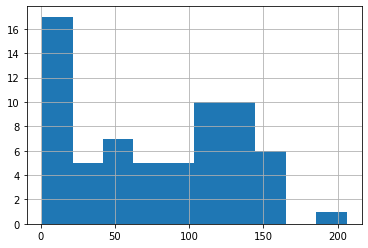

In [6]:
data_analisis.groupby(by='Edad').count().reset_index().sort_values(by='Edad')['Y'].hist()

In [7]:
###Función que permite discretizar una variable cuantitativa
def cate(x):
    if x['Edad']<=34:
        return '34'
    elif x['Edad']>34 and x['Edad']<=41:
        return '34-41'
    elif x['Edad']>41 and x['Edad']<=48:
        return '40-48'
    elif x['Edad']>48 and x['Edad']<=57:
        return '48-57'
    else:
        return '57'
        
##Crear una nueva variable denominada "grupo_edad"
data_analisis['grupo_edad']=data_analisis.apply(cate,axis=1)
data_analisis.groupby(by='grupo_edad').count()

,CUENTA_TDC,HABITO_PAGO_TDC,SALDO_TDC,SALDO_CC,SALDO_SBG,CUPO_TDC,CUPO_CC,CUPO_SBG,Edad,estrato,NOMBRE_CIUDAD,DEPARTAMENTO,ACT_ECO,SEXO,NIVEL_EST,SALDO_TOTAL,CUPO_TOTAL,Y
grupo_edad,,,,,,,,,,,,,,,,,,
34,972,956,972,972,972,972,972,972,972,972,967,967,972,971,972,972,972,972
34-41,949,935,949,949,949,949,949,949,949,949,944,944,949,949,949,949,949,949
40-48,994,979,994,994,994,994,994,994,994,994,990,990,929,929,929,994,994,994
48-57,1050,1038,1050,1050,1050,1050,1050,1050,1050,1050,1046,1046,1050,1050,1050,1050,1050,1050
57,1035,1029,1035,1035,1035,1035,1035,1035,1035,1035,1030,1030,1035,1035,1035,1035,1035,1035


In [8]:
data_analisis=data_analisis.drop(['Edad'],axis=1)

In [9]:
##Frecuencia absoluta
pd.value_counts(data_analisis['grupo_edad'])

48-57    1050
57       1035
40-48     994
34        972
34-41     949
Name: grupo_edad, dtype: int64

In [10]:
## Frecuencia relativa
100 * data_analisis['grupo_edad'].value_counts() / len(data_analisis['grupo_edad'])

48-57    21.00
57       20.70
40-48    19.88
34       19.44
34-41    18.98
Name: grupo_edad, dtype: float64

A continuación, se redefine la variable y de la siguiente forma:

In [11]:
data_analisis.dtypes

CUENTA_TDC           int64
HABITO_PAGO_TDC     object
SALDO_TDC          float64
SALDO_CC           float64
SALDO_SBG          float64
CUPO_TDC             int64
CUPO_CC            float64
CUPO_SBG             int64
estrato              int64
NOMBRE_CIUDAD       object
DEPARTAMENTO        object
ACT_ECO             object
SEXO                object
NIVEL_EST           object
SALDO_TOTAL        float64
CUPO_TOTAL         float64
Y                    int64
grupo_edad          object
dtype: object

In [12]:
data_analisis['estrato']=data_analisis['estrato'].astype(int)

In [13]:
data_analisis.shape

(5000, 18)

### A continuación se realizar una selección aleatoria de datos de entrenamiento, validación y test. *

Convertir variables categóricas a dummies.

In [14]:
data_model = pd.get_dummies(data_analisis)
data_model.shape

(5000, 92)

In [15]:
data_model.dtypes

CUENTA_TDC            int64
SALDO_TDC           float64
SALDO_CC            float64
SALDO_SBG           float64
CUPO_TDC              int64
                     ...   
grupo_edad_34         uint8
grupo_edad_34-41      uint8
grupo_edad_40-48      uint8
grupo_edad_48-57      uint8
grupo_edad_57         uint8
Length: 92, dtype: object

A continuación, se realiza una partición sobre la data.

In [16]:
###Partición de la data sobre entrenamiento y validacion.
y = data_model['Y']
X = data_model.drop(['Y'],axis=1)

##Selección data de entrenamiento y test
X_train, X_test_pre, y_train, y_test_pre = train_test_split(X, y, test_size=0.3, random_state=3)

##Selección data de test y developer para tunnear los hiperparámetros
X_dev, X_test, Y_dev, Y_test =  train_test_split(X_test_pre, y_test_pre, test_size=0.5, random_state=3)


## Random Forest 

### Para obtener los hiperparámetros de un modelo random forest

In [21]:
def eval_model(X_train, y_train, X_test, y_test):
    """
    Función para obtener los hiperparámetros del modelo random forest.
    Parámetros: Recibe como parámetros los datos de entrenamiento y los datos de desarrollo.
    únicamente encuentra la mejor combinaciones de los marámetros n_estimators, learning_rate,
    max_depth, max_features.       
    """
    vector_n_estimators=[10, 20, 30]  ## si va
    lr_list = [1]   ## No va
    vector_max_depth=[9, 12, 15]  ## si va
    max_features=[9, 12, 14] ## si va
    for r in lr_list:
        for p in vector_max_depth:
            for f in max_features:
                for e in vector_n_estimators:
                    alg = RandomForestClassifier(n_estimators=e, 
                                                     #learning_rate=r, 
                                                     max_features=f, 
                                                     max_depth=p, 
                                                     random_state=0)
                    ##Inicio del entrenamiento
                    alg.fit(X_train, y_train)
                    # Para comenzar con la prediccion sobre test
                    predictions = alg.predict(X_test)
                    pred_proba = alg.predict_proba(X_test)[:, 1]
                    # Para comenzar con la predicción sobre train
                    predictions_train = alg.predict(X_train)
                    pred_proba_train = alg.predict_proba(X_train)[:, 1]
                    dif_accuracy = abs(metrics.f1_score(y_train, predictions_train) - metrics.f1_score(y_test, predictions))
                    ##Para imprimer las predicciones sobre cada combinación de hiperparámetros.
                    print("#####################################")
                    print("max_depth: ", p, "max_features: ", f, "n_estimators: ", e)
                    print("#####################################")
                    print("f1_score sobre datos de train")
                    print(metrics.f1_score(y_train, predictions_train))
                    print('f1_score sobre datos de desarrollo')
                    print(metrics.f1_score(y_test, predictions))
                    print("Diferencia entre el f1_score obtenido en test y desarrollo")
                    print(dif_accuracy)
                    
##Para aplicar la fución anterior.  
eval_model(X_train, y_train, X_dev, Y_dev)  

#####################################
max_depth:  9 max_features:  12 n_estimators:  5
#####################################
f1_score sobre datos de train
0.2600896860986547
f1_score sobre datos de desarrollo
0.05555555555555555
Diferencia entre el f1_score obtenido en test y desarrollo
0.20453413054309913
#####################################
max_depth:  9 max_features:  12 n_estimators:  10
#####################################
f1_score sobre datos de train
0.29333333333333333
f1_score sobre datos de desarrollo
0.05714285714285715
Diferencia entre el f1_score obtenido en test y desarrollo
0.23619047619047617
#####################################
max_depth:  9 max_features:  12 n_estimators:  20
#####################################
f1_score sobre datos de train
0.2465753424657534
f1_score sobre datos de desarrollo
0.0
Diferencia entre el f1_score obtenido en test y desarrollo
0.2465753424657534
#####################################
max_depth:  9 max_features:  15 n_estimators:  5
###

### Importante 
Los mejores hiperparámetros para el random forest son: max_depth:  9 max_features:  12 n_estimators:  100

### Función para estimar el modelo basado en random forest con los hiperparámetros seleccionados y aplicarlos sobre la data de test 

Inicio entrenamiento
Iniciar la predicciòn
Metricas al aplicar el modelo sobre los datos de train 
Accuracy sobtr train
0.9737142857142858
AUC sobre train
0.9935250088170093
Matriz de confusion sobre train
[[3308    0]
 [  92  100]]
Recall sobre train
0.5208333333333334
Precision sobre train
1.0
f1-Score sobre train
0.684931506849315
Reporte clasificación sobre train
              precision    recall  f1-score   support

           0       0.97      1.00      0.99      3308
           1       1.00      0.52      0.68       192

    accuracy                           0.97      3500
   macro avg       0.99      0.76      0.84      3500
weighted avg       0.97      0.97      0.97      3500

Metricas al aplicar el modelo sobre los datos de test  
Accuracy sobre test
0.9453333333333334
AUC sobre test
0.7965957446808511
Matriz de confusion sobre test
[[703   2]
 [ 39   6]]
Recall sobre test
0.13333333333333333
Precision sobre test
0.75
f1-Score sobre test
0.22641509433962267
Reporte clasific

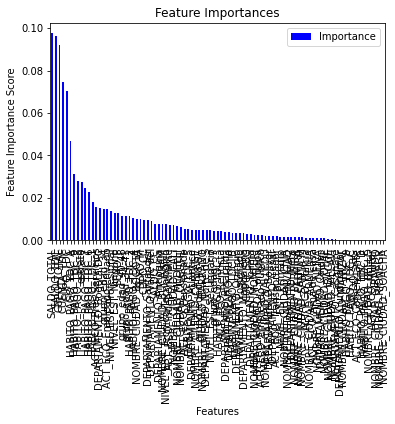

                 Features  Importance
8             SALDO_TOTAL    0.097519
1               SALDO_TDC    0.096375
9              CUPO_TOTAL    0.091924
0              CUENTA_TDC    0.074607
4                CUPO_TDC    0.070380
..                    ...         ...
27    NOMBRE_CIUDAD_BELLO    0.000000
72        ACT_ECO_Militar    0.000000
35  NOMBRE_CIUDAD_GIRARDO    0.000000
43  NOMBRE_CIUDAD_RIONEGR    0.000000
45   NOMBRE_CIUDAD_SOACHA    0.000000

[91 rows x 2 columns]
['SALDO_TOTAL', 'SALDO_TDC', 'CUPO_TOTAL', 'CUENTA_TDC', 'CUPO_TDC', 'HABITO_PAGO_TDC_A', 'HABITO_PAGO_TDC_9', 'HABITO_PAGO_TDC_8', 'estrato', 'HABITO_PAGO_TDC_7', 'HABITO_PAGO_TDC_6', 'HABITO_PAGO_TDC_1', 'ACT_ECO_Pres Servicios', 'DEPARTAMENTO_Bogotá D.C', 'grupo_edad_34', 'ACT_ECO_Empleado Privado', 'NIVEL_EST_Profesional', 'NIVEL_EST_Ninguno', 'SEXO_F', 'grupo_edad_40-48', 'grupo_edad_34-41', 'HABITO_PAGO_TDC_2', 'HABITO_PAGO_TDC_4', 'NOMBRE_CIUDAD_BOGOTA', 'SEXO_M', 'CUPO_CC', 'DEPARTAMENTO_Santander', 'DEPARTA

In [22]:
def tree_classifier(X_train, X_test, y_train, y_test):
    """
    Función para estimar un modelo utilizando random forest 
    Esta funciòn recibe como parametros los datos de entrenamiento y de test
    Finalmente, imprime el AUC, f1-score, precision, recall, accuracy
    por cada clase, tanto para la data de entrenamiento, como la de test.
    Finaalmente, esta función también imprime la importancia de las variables.
       
    """
    alg = RandomForestClassifier(n_estimators=10, 
                                #learning_rate=r, 
                                max_features=14, 
                                max_depth=15, 
                                random_state=0)
    # Entrenamiento
    print('Inicio entrenamiento')
    alg.fit(X_train, y_train)
    # Guardar el modelo en disco en el siguiente directorio
    # save the model to disk
    #%cd C:\Users\\USUARIO\\Documents\\Monitoria_cda_2019_2\\Clases_Python\\Clase8_Python
    #filename = 'finalized_model.sav'
    #joblib.dump(alg, filename)

    # Para comenzar con la prediccion
    print("Iniciar la predicciòn")
    predictions = alg.predict(X_test)
    pred_proba = alg.predict_proba(X_test)[:, 1]
    
    predictions_train = alg.predict(X_train)
    pred_proba_train = alg.predict_proba(X_train)[:, 1]
    
    #Para imprimir las metricas al aplicar el modelo sobre los datos de train
    
    # Para imprimir las métricas al aplicar el modelo sobre los datos de test
    print("Metricas al aplicar el modelo sobre los datos de train ")
    print("Accuracy sobtr train")
    print(metrics.accuracy_score(y_train, predictions_train))
    print("AUC sobre train")
    print(metrics.roc_auc_score(y_train, pred_proba_train))
    print("Matriz de confusion sobre train")
    print(confusion_matrix(y_train, predictions_train))
    print("Recall sobre train")
    print(metrics.recall_score(y_train, predictions_train))
    print("Precision sobre train")
    print(metrics.precision_score(y_train, predictions_train))
    print("f1-Score sobre train")
    print( metrics.f1_score(y_train, predictions_train))
    print("Reporte clasificación sobre train")
    print(classification_report(y_train, predictions_train))

    # Para imprimir las métricas al aplicar el modelo sobre los datos de test
    print("Metricas al aplicar el modelo sobre los datos de test  ")
    print("Accuracy sobre test")
    print(metrics.accuracy_score(y_test, predictions))
    print("AUC sobre test")
    print(metrics.roc_auc_score(y_test, pred_proba))
    print("Matriz de confusion sobre test")
    print(confusion_matrix(y_test, predictions))
    print("Recall sobre test")
    print(metrics.recall_score(y_test, predictions))
    print("Precision sobre test")
    print(metrics.precision_score(y_test, predictions))
    print("f1-Score sobre test")
    print( metrics.f1_score(y_test, predictions))
    print("Reporte clasificación sobre test")
    print(classification_report(y_test, predictions))
    
    feat_imp = alg.feature_importances_
    feat = X_train.columns.tolist()
    # clf.best_estimator_.booster().get_fscore()
    res_df = pd.DataFrame({'Features': feat, 'Importance': feat_imp}).sort_values(by='Importance', ascending=False)
    res_df.plot('Features', 
                'Importance', 
                kind='bar', 
                title='Feature Importances',
                color= "blue")
    plt.ylabel('Feature Importance Score')
    plt.show()
    print(res_df)
    print(res_df["Features"].tolist())

tree_classifier(X_train, X_test, y_train, Y_test)